# Detecting Fake News Using Naive Bayes
The dataset used is: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset/data

# Table of Contents

1. [Data Preprocessing](#data-preprocessing)  
   - [Feature Extraction & Data Splitting](#feature-extraction)  
2. [Model Training](#model-training)  
3. [Model Evaluation](#model-evaluation)  


#### Required libraries

In [41]:
%pip install numpy pandas scikit-learn matplotlib seaborn

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.
Note: you may need to restart the kernel to use updated packages.


## Data Preprocessing

In [42]:
import pandas as pd
import numpy as np

#### Load Datasets

In [3]:
real_df = pd.read_csv('True.csv')
fake_df = pd.read_csv('Fake.csv')

#### Explore the data

In [4]:
real_df.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
real_df.describe()

,title,text,subject,date
count,21417,21417,21417,21417
unique,20826,21192,2,716
top,Factbox: Trump fills top jobs for his administ...,(Reuters) - Highlights for U.S. President Dona...,politicsNews,"December 20, 2017"
freq,14,8,11272,182


In [6]:
fake_df.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [7]:
fake_df.describe()

,title,text,subject,date
count,23481,23481,23481,23481
unique,17903,17455,6,1681
top,MEDIA IGNORES Time That Bill Clinton FIRED His...,,News,"May 10, 2017"
freq,6,626,9050,46


#### Check for null values

In [8]:
real_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

In [9]:
fake_df.isnull().sum()

title      0
text       0
subject    0
date       0
dtype: int64

#### Adding a column value to represent wheter the Article is labeled real (1) or fake(0)

In [10]:
real_df["label"] = 1 
fake_df["label"] = 0 

#### Combine the modified Real and Fake News Datasets

In [11]:
df = pd.concat([real_df, fake_df], axis=0).reset_index(drop=True)


In [12]:
df.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


#### Check for articles with empty string titles or text

In [13]:
empty_text = df[df["text"].str.strip() == ""]
empty_text

,title,text,subject,date,label
8970,Graphic: Supreme Court roundup,,politicsNews,"June 16, 2016",1
32340,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017",0
32458,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017",0
32607,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017",0
32642,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017",0
...,...,...,...,...,...
43233,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015",0
43243,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015",0
43244,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015",0
43274,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015",0


In [14]:
empty_titles = df[df["title"].str.strip() == ""]
empty_titles

,title,text,subject,date,label


#### Concatenating Title and Text into a Single Column

Some articles have empty text, but every article has a title with data. To ensure that all articles contribute meaningful information to the model, we concatenate the title and text into a single column. This prevents articles with missing text from relying solely on the prior probability P(Y) for classification by allowing the model to learn from also the title content and thus make better predictions.

In [15]:
df["title_and_text"] = df["title"] + " " + df["text"]
df.head()

,title,text,subject,date,label,title_and_text
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1,"As U.S. budget fight looms, Republicans flip t..."
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1,U.S. military to accept transgender recruits o...
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1,Senior U.S. Republican senator: 'Let Mr. Muell...
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1,FBI Russia probe helped by Australian diplomat...
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1,Trump wants Postal Service to charge 'much mor...


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import re

#### Feature Extraction & Data Splitting

In [17]:
X_text = df["text"]  # Features (news article content)
y = df["label"]  # Labels (1 = Real, 0 = Fake)

# Convert text into numerical features using TF-IDF
vectorizer = TfidfVectorizer(stop_words="english", min_df = 5)
X = vectorizer.fit_transform(X_text)

In [18]:
# 70% training, 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=0)

#### Model Training

In [19]:
model = MultinomialNB(alpha = 1) # alpha is an additive Laplace smoothing parameter, helps take care of unseen words
model.fit(X_train, y_train)

MultinomialNB(alpha=1)

#### Model Evaluation

Conditional Probability Table values

In [20]:
# Extract Prior Probabilities P(Y)
prior_log_probs = model.class_log_prior_ 
priors = np.exp(prior_log_probs)  

# Display priors
print("Prior Probabilities (P(Y)):")
print(f"P(Real) = {priors[1]:.4f}")
print(f"P(Fake) = {priors[0]:.4f}")

Prior Probabilities (P(Y)):
P(Real) = 0.4778
P(Fake) = 0.5222


Likelihoods: P(word|Article=Real),  P(word|Article=Fake)

In [21]:

# Get log probabilities learned by Naïve Bayesb
log_probs = model.feature_log_prob_

# Converting log probabilities to actual probabilities
probs = np.exp(log_probs)

# Get vocabulary (word list)
feature_names = vectorizer.get_feature_names_out()

# Compute the difference for Real News words (Real - Fake)
real_word_importance = probs[1] - probs[0]  # Positive values mean more Real-like

# Compute the difference for Fake News words (Fake - Real)
fake_word_importance = probs[0] - probs[1]  # Positive values mean more Fake-like

# Get indices of the top 5 most Real-indicative words (ensuring valid range)
top_real_indices = np.argsort(real_word_importance)[-5:][::-1]  # Get highest 5
top_real_indices = [i for i in top_real_indices if i < len(feature_names)]  # Ensure within bounds

# Get indices of the top 5 most Fake-indicative words (ensuring valid range)
top_fake_indices = np.argsort(fake_word_importance)[-5:][::-1]  # Get highest 5
top_fake_indices = [i for i in top_fake_indices if i < len(feature_names)]  # Ensure within bounds


In [22]:
# Print top 5 real-indicating words
print("Top 5 Words Indicating Real News:")
print("=" * 40)
for i in top_real_indices:
    print(f"Word: {feature_names[i]}")
    print(f"P(word | Fake): {probs[0, i]:.6f}")
    print(f"P(word | Real): {probs[1, i]:.6f}")
    print("------")

Top 5 Words Indicating Real News:
Word: said
P(word | Fake): 0.001540
P(word | Real): 0.005339
------
Word: reuters
P(word | Fake): 0.000033
P(word | Real): 0.002602
------
Word: washington
P(word | Fake): 0.000425
P(word | Real): 0.001566
------
Word: minister
P(word | Fake): 0.000102
P(word | Real): 0.001240
------
Word: china
P(word | Fake): 0.000153
P(word | Real): 0.001211
------


In [23]:
# Print top 5 fake-indicating words
print("\nTop 5 Words Indicating Fake News:")
print("=" * 40)
for i in top_fake_indices:
    print(f"Word: {feature_names[i]}")
    print(f"P(word | Fake): {probs[0, i]:.6f}")
    print(f"P(word | Real): {probs[1, i]:.6f}")
    print("------")


Top 5 Words Indicating Fake News:
Word: trump
P(word | Fake): 0.005278
P(word | Real): 0.003733
------
Word: hillary
P(word | Fake): 0.001610
P(word | Real): 0.000334
------
Word: just
P(word | Fake): 0.001575
P(word | Real): 0.000333
------
Word: com
P(word | Fake): 0.001141
P(word | Real): 0.000028
------
Word: like
P(word | Fake): 0.001415
P(word | Real): 0.000370
------


P(Article=True|word1, ..., wordn), P(Article=Fake|word1, ..., wordn)

In [38]:
# Select a random test sample
random_index = np.random.randint(0, X_test.shape[0])  # Fix: Use shape[0]
article_tfidf = X_test[random_index]  # TF-IDF representation
actual_label = y_test.iloc[random_index]  # True label (1 = Real, 0 = Fake)

original_article = df.iloc[y_test.index[random_index]]["title_and_text"]

def predict_article_probabilities(article_tfidf):
    # Get log probabilities from the Naïve Bayes model
    log_prior_probs = model.class_log_prior_  # Log P(Y)
    log_likelihood_probs = model.feature_log_prob_  # Log P(X | Y)
    
    # Compute log joint probability for Fake and Real
    log_prob_fake = log_prior_probs[0] + article_tfidf @ log_likelihood_probs[0].T  # Log P(Fake | X)
    log_prob_real = log_prior_probs[1] + article_tfidf @ log_likelihood_probs[1].T  # Log P(Real | X)

    # Convert log probabilities to actual probabilities
    prob_fake = np.exp(log_prob_fake).item()  
    prob_real = np.exp(log_prob_real).item() 

    # Normalize so they sum to 1
    total_prob = prob_fake + prob_real
    prob_fake /= total_prob
    prob_real /= total_prob

    return prob_real, prob_fake  

prob_real, prob_fake = predict_article_probabilities(article_tfidf)

# Display results
print("Selected Test Article:")
print(original_article[:200]) 
print("\nPredicted Probabilities:")
print(f"P(Real | Words in Article) = {prob_real:.4f}")
print(f"P(Fake |  Words in Article)) = {prob_fake:.4f}")
print("\nActual Label:", "Real" if actual_label == 1 else "Fake")


Selected Test Article:
India agrees to hold talks on Afghanistan with U.S., Kabul NEW DELHI (Reuters) - India has agreed to hold talks on Afghanistan with the United States and Kabul, Indian Foreign Minister Sushma Swaraj s

Predicted Probabilities:
P(Real | Words in Article) = 0.9945
P(Fake |  Words in Article)) = 0.0055

Actual Label: Real


In [39]:
# Make predictions on the test set
y_pred = model.predict(X_test)

# Print accuracy
print(f"Model Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Print classification report (Precision, Recall, F1-score)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Model Accuracy: 0.9362

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      7069
           1       0.93      0.93      0.93      6401

    accuracy                           0.94     13470
   macro avg       0.94      0.94      0.94     13470
weighted avg       0.94      0.94      0.94     13470



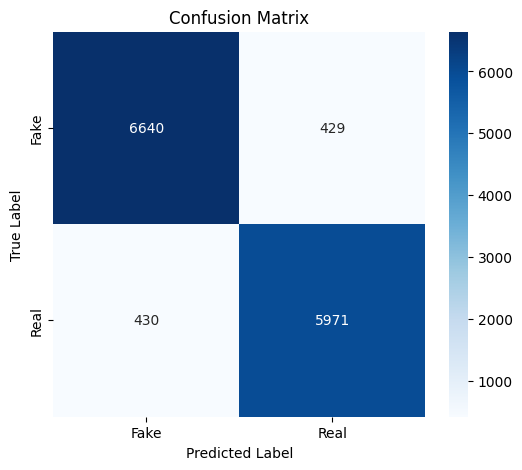

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Define class labels
labels = ["Fake", "Real"]

# Plot confusion matrix heatmap
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Add labels and title
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
